# Conflations

In [1]:
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal

from fooof import Bands
from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum_shading

## Settings

In [2]:
# Define our bands of interest
bands = Bands({'delta' : [2, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 25]})

shade_colors = ['#e8dc35', '#46b870', '#1882d9', '#a218d9']

In [3]:
fs = 1000
n_seconds = 25

In [4]:
times = create_times(n_seconds, fs)

In [5]:
SAVE_FIG = False

In [6]:
white = sim_powerlaw(n_seconds, fs, 0)
pink = sim_powerlaw(n_seconds, fs, -1)

In [7]:
filt_xlim = [5, 8]
filt_ylim = [-0.5, 0.5]

plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'lw' : 3}

In [8]:
plot_data = white

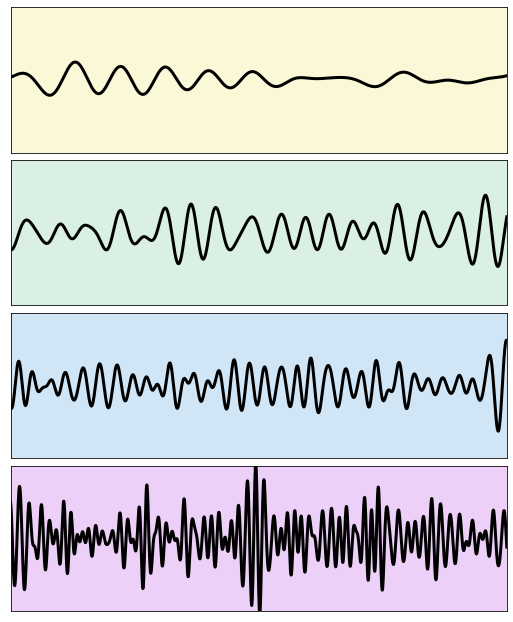

In [9]:
# Create a plot of the data filtered into different frequency ranges
_, axes = plt.subplots(len(bands), 1, figsize=(8, 9))
for ax, color, (label, f_range) in zip(axes, shade_colors, bands):

    band_sig = filter_signal(plot_data, fs, 'bandpass', f_range)
    plot_time_series(times, band_sig, ax=ax,
                     xlim=filt_xlim, ylim=filt_ylim, **plt_kwargs)
    ax.axvspan(filt_xlim[0], filt_xlim[1], alpha=0.2, color=color)
    ax.set_xticks([]); ax.set_yticks([]); 
    
plt.subplots_adjust(hspace=0.05)
if SAVE_FIG:
    plt.savefig('white_noise_filters.svg', dpi=300)

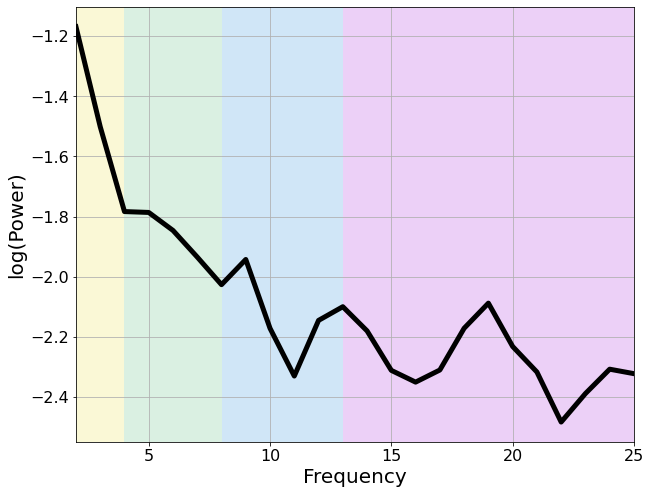

In [10]:
# Plot the power spectrum of the simulated signal
freqs, powers = trim_spectrum(*compute_spectrum(pink, fs, nperseg=fs), [2, 25])
plot_spectrum_shading(freqs, powers, lw=5, color='black', log_powers=True,
                      shades=bands.definitions, shade_colors=shade_colors)

plt.xlim([2, 25])
#plt.ylim([-2.2, -1.25])
if SAVE_FIG:
    plt.savefig('pink_noise_psd.pdf')

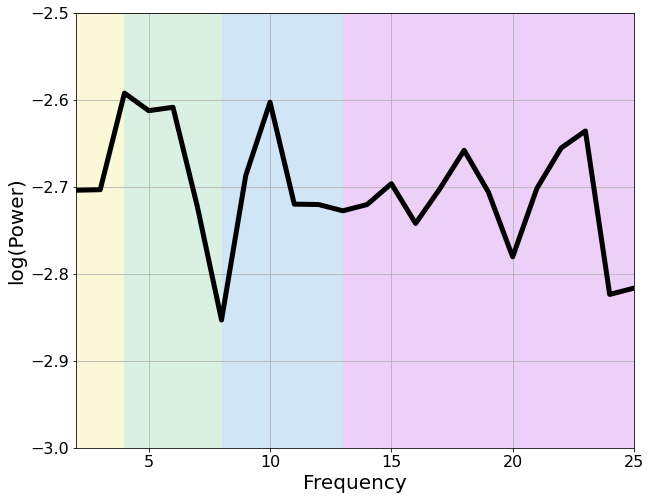

In [11]:
# Plot the power spectrum of the simulated signal
freqs, powers = trim_spectrum(*compute_spectrum(white, fs, nperseg=fs), [2, 25])
plot_spectrum_shading(freqs, powers, lw=5, color='black', log_powers=True,
                      shades=bands.definitions, shade_colors=shade_colors)

plt.xlim([2, 25])
plt.ylim([-3, -2.5])
if SAVE_FIG:
    plt.savefig('white_noise_psd.pdf')